In [1]:
import numpy as np
from simulator.csad import CSAD_DP_6DOF
from Observer.EKF import EKF

dt = 0.005
N = 50000

# Create vessel and observer objects
system = CSAD_DP_6DOF(dt)
KalmanFilter = EKF(dt, system._M, system._D)

# Allocate memory to save variables
storage_state = np.zeros((N,19))
storage_observer = np.zeros((N, 75))

x = np.zeros(15)
np.random.seed(1234)

# Simulation:
for i in range(N):

    t = (i+1)*system._dt

    # Thruster forces
    tau = np.array([0*np.sin(t),0,0,0,0,0])

    # Current
    U = 0.05         # m/s
    beta_u = 45     # deg

    # Wave forces
    tau_w = 0

    # Calculate x_dot and integrate
    system.x_dot(U, np.deg2rad(beta_u), tau)                   # U, beta, tau
    system.integrate()

    # Measurement
    noise = np.concatenate((np.random.normal(0,.167,size=3),np.random.normal(0,.017,size=3)))
    y = np.array(system.get_eta() + noise)
    y_obs = np.array([y[0], y[1], y[5]])

    # Observer
    KalmanFilter.corrector(y_obs)
    KalmanFilter.predictor(np.array([tau[0], tau[1], tau[5]]))
    
    x_hat = KalmanFilter.x_hat
    P_hat = KalmanFilter.P_hat
    K = KalmanFilter.EKF_gain

    # Controller
    # = 0
    
    # Save for storage
    storage_state[i] = np.concatenate([t, system.get_eta(),y, system.get_nu()], axis=None)
    storage_observer[i] = np.concatenate([x_hat, np.diag(P_hat), K[:,0], K[:,1], K[:,2]], axis=None)
# end

# Store data for plotting
t = storage_state[:,0]
eta = storage_state[:,1:7]
y = storage_state[:,7:13]
nu = storage_state[:, 13:19]

xi_hat = storage_observer[:,0:6]
eta_hat = storage_observer[:,6:9]
b_hat = storage_observer[:,9:12]
nu_hat = storage_observer[:,12:15]
var = storage_observer[:,15:30]
K_surge = storage_observer[:, 30:45]
K_sway = storage_observer[:, 45:60]
K_yaw = storage_observer[:, 60:75]


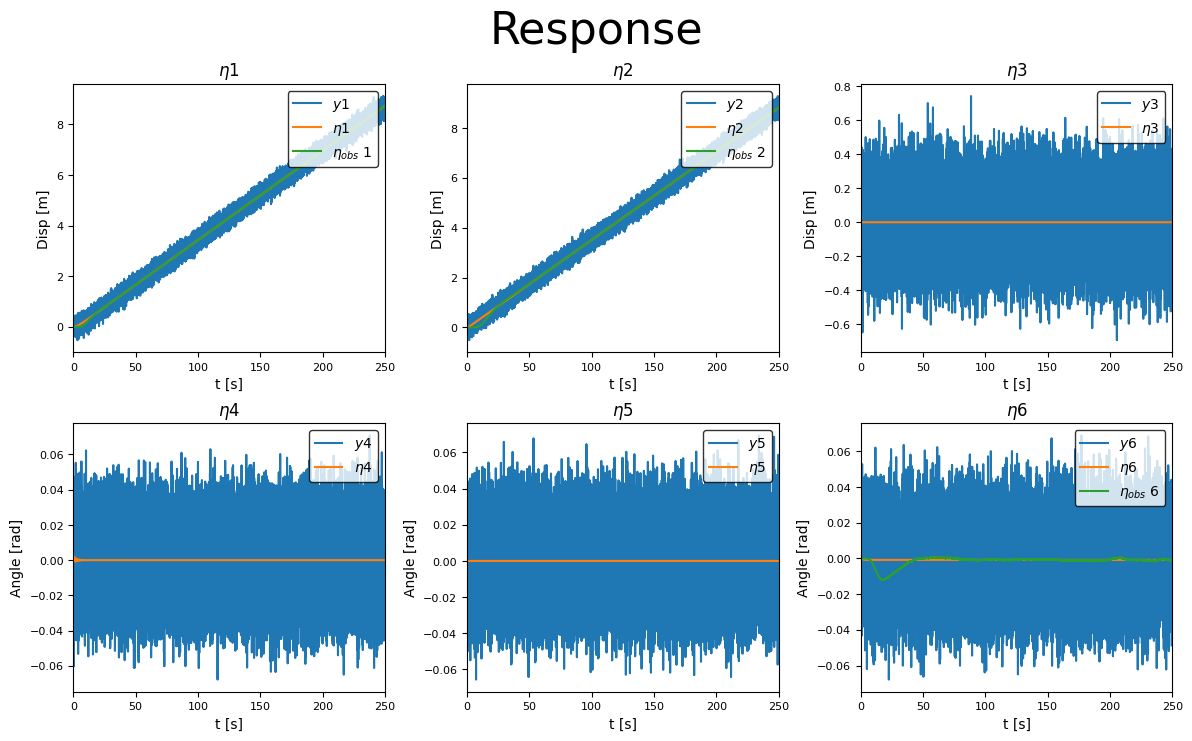

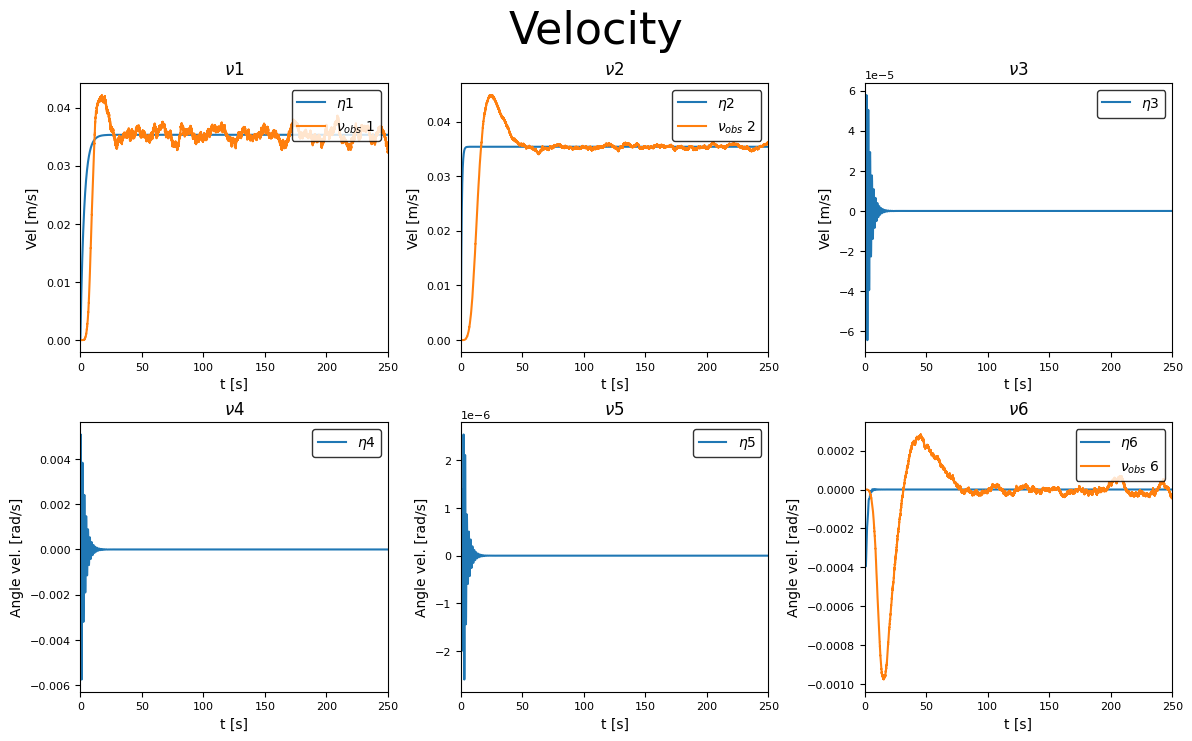

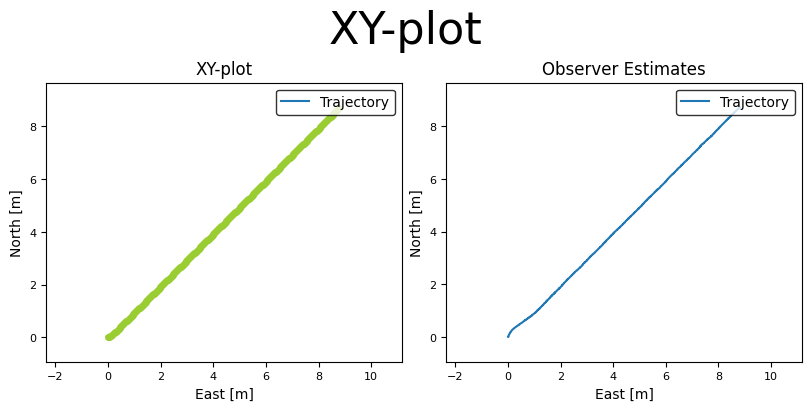

In [2]:
# Results
import matplotlib.pyplot as plt

# Set up the plotting parameters. ------------------------------------------
width = 426.8*2             # Latex document width in pts
inch_pr_pt = 1/72.27        # Ratio between pts and inches
golden_ratio = (np.sqrt(5) - 1)/2
fig_width = width*inch_pr_pt
fig_height = fig_width*golden_ratio
fig_size = [fig_width, fig_height]
params = {#'backend': 'PS',
          'axes.labelsize': 10,
          'font.size': 10,
          'legend.fontsize': 10,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'axes.grid': True,
          #'text.usetex': True,
          'figure.constrained_layout.use': True,
          'figure.figsize': fig_size
          } 
plt.rcParams.update(params)


# Plot response --------------------------------------------------------------
fig, axs = plt.subplots(2, 3)
i_obs=0
for i in range(2):
    for j in range(3):
        DOF = j+1+3*i
        axs[i,j].plot(t, y[:,DOF-1], label=r'$y$'+str(DOF))
        axs[i,j].plot(t, eta[:, DOF-1], label=r'$\eta$'+str(DOF))
        axs[i,j].grid()
        axs[i,j].set_xlim([0,dt*N])
        axs[i,j].set_xlabel('t [s]')
        axs[i,j].set_title(r'$\eta $'  + str(DOF))
        if i == 1:
            axs[i,j].set_ylabel('Angle [rad]')
        else:
            axs[i,j].set_ylabel('Disp [m]')  
        if DOF in [1,2,6]: 
            axs[i,j].plot(t, eta_hat[:,i_obs], label=r'$\eta_{obs} $ '+str(DOF))
            i_obs+=1
            # axs[i,j].set_ylim([min(y[:, DOF-1]),max(y[:,DOF-1])])
        
        axs[i,j].legend(loc="upper right", edgecolor="k")

plt.tight_layout()
plt.suptitle('Response', fontsize=32)
plt.show()

fig, axs = plt.subplots(2, 3)
i_obs=0
for i in range(2):
    for j in range(3):
        DOF = j+1+3*i
        axs[i,j].plot(t, nu[:, DOF-1], label=r'$\eta$'+str(DOF))
        axs[i,j].grid()
        axs[i,j].set_xlim([0,dt*N])
        axs[i,j].set_xlabel('t [s]')
        axs[i,j].set_title(r'$\nu $'  + str(DOF))
        if i == 1:
            axs[i,j].set_ylabel('Angle vel. [rad/s]')
        else:
            axs[i,j].set_ylabel('Vel [m/s]')  
        if DOF in [1,2,6]: 
            axs[i,j].plot(t, nu_hat[:,i_obs], label=r'$\nu_{obs} $ '+str(DOF))
            i_obs+=1
            # axs[i,j].set_ylim([min(y[:, DOF-1]),max(y[:,DOF-1])])
        
        axs[i,j].legend(loc="upper right", edgecolor="k")

plt.tight_layout()
plt.suptitle('Velocity', fontsize=32)
plt.show()


plt.figure(figsize=(8,4))
plt.suptitle('XY-plot', fontsize=32)
plt.subplot(121) 
plt.plot(eta[:,1], eta[:,0], label='Trajectory')
for i in range(len(eta[:,0])):
    if i%200 == 0:
        plt.plot(eta[i,1], eta[i,0],marker="o", markersize=4, color='yellowgreen')
plt.grid()
plt.title('XY-plot')
plt.legend(loc="upper right", edgecolor="k")
plt.xlabel('East [m]')
plt.ylabel('North [m]')
plt.axis('equal')
plt.subplot(122)
plt.plot(eta_hat[:,1], eta_hat[:,0], label='Trajectory')
'''
for i in range(len(eta_hat[:,0])):
    if i%200 == 0:
        plt.plot(eta_hat[i,1], eta_hat[i,0],marker="o", markersize=4, color='yellowgreen')
'''
plt.grid()
plt.title('Observer Estimates')
plt.legend(loc="upper right", edgecolor="k")
plt.xlabel('East [m]')
plt.ylabel('North [m]')
plt.axis('equal')
plt.show()


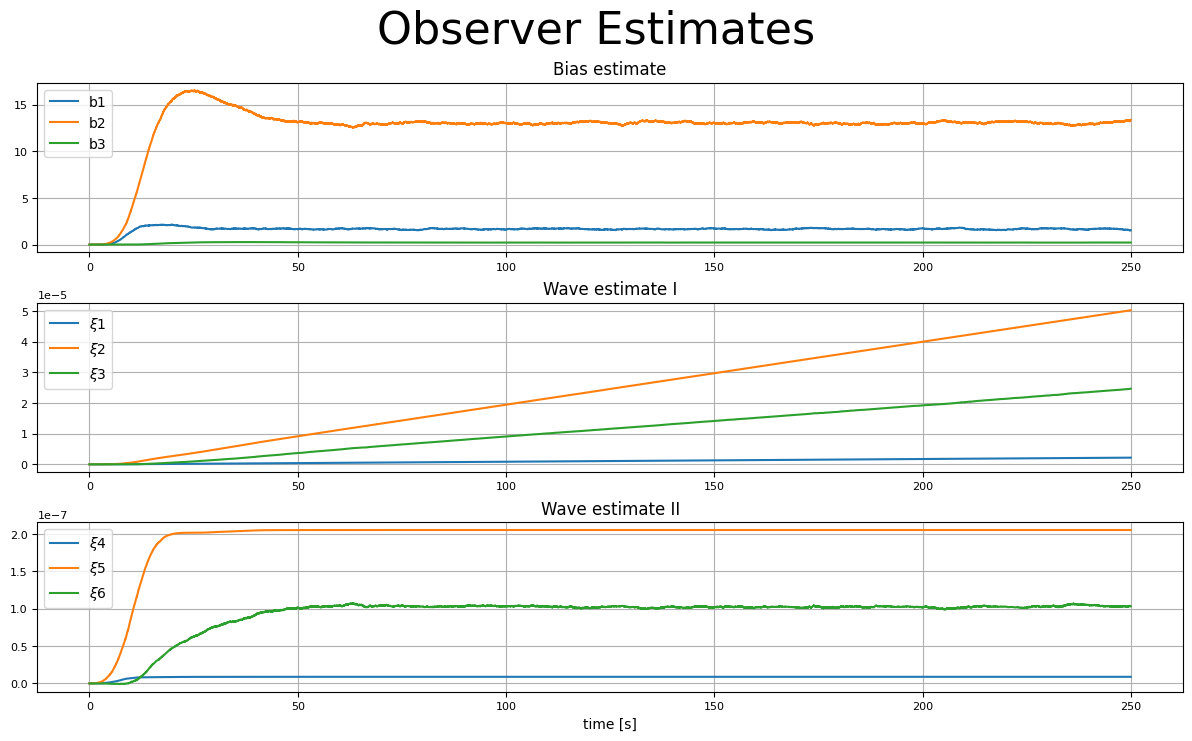

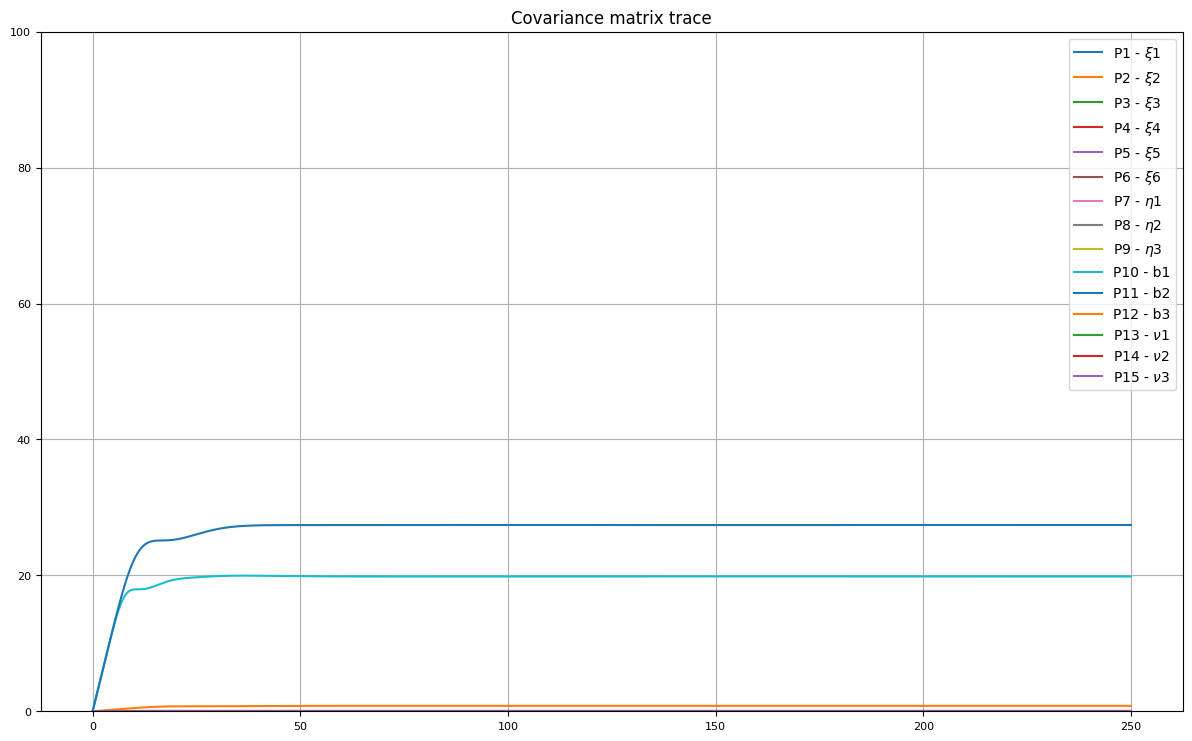

In [3]:
# Plot observer
observer_legends = [r'$\xi1$', r'$\xi2$', r'$\xi3$', r'$\xi4$', r'$\xi5$', r'$\xi6$', r'$\eta1$', r'$\eta2$', r'$\eta3$', 'b1', 'b2', 'b3', r'$\nu1$',r'$\nu2$',r'$\nu3$']
plt.subplot(311)
plt.suptitle('Observer Estimates', fontsize=32)
plt.title('Bias estimate')
for i in range(3):
    plt.plot(t, b_hat[:, i], label='b'+str(i+1))
plt.legend()

plt.subplot(312)
plt.title('Wave estimate I')
for i in range(3):
    plt.plot(t, xi_hat[:,i], label=r'$\xi$'+ str(i+1))
plt.legend()
plt.subplot(313)
plt.title('Wave estimate II')
for i in range(3):
    plt.plot(t, xi_hat[:,i+3], label=r'$\xi$'+ str(i+4))
plt.legend()
plt.xlabel('time [s]')
plt.show()

plt.figure()
plt.subplot(111)
for i in range(len(var[0])):
    plt.plot(t, var[:,i], label= 'P' + str(i+1) + ' - ' + observer_legends[i])
plt.legend()
plt.title('Covariance matrix trace')
plt.ylim([0,100])
plt.show()

for i in range(15):
    if var[:,i][-1]-var[:,i][-5000]>5:
        print(i+1)

In [4]:
# Lek og lær

a = np.array([[1,2,3],[1,2,3], [1,2,3]])
b = np.arange(0,9).reshape((3,3))

print(a@b)

print(a@b.T)

print(a@(b.T))

print((a@b).T)

[[24 30 36]
 [24 30 36]
 [24 30 36]]
[[ 8 26 44]
 [ 8 26 44]
 [ 8 26 44]]
[[ 8 26 44]
 [ 8 26 44]
 [ 8 26 44]]
[[24 24 24]
 [30 30 30]
 [36 36 36]]
